In [1]:
import torch
from networks.DVT import converters
import datasets
from config import config_MOS as config
from networks import backbone
import deep_point
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

In [20]:
def VoxelMaxPool(pcds_feat, pcds_ind, output_size, scale_rate):
    voxel_feat = deep_point.VoxelMaxPool(
        pcds_feat=pcds_feat.contiguous(),
        pcds_ind=pcds_ind.contiguous(),
        output_size=output_size,
        scale_rate=scale_rate,
    ).to(pcds_feat.dtype)
    return voxel_feat

def VoxelMinPool(pcds_feat, pcds_ind, output_size, scale_rate):
    voxel_feat = deep_point.VoxelMinPool(
        pcds_feat=pcds_feat.contiguous(),
        pcds_ind=pcds_ind.contiguous(),
        output_size=output_size,
        scale_rate=scale_rate,
    ).to(pcds_feat.dtype)
    return voxel_feat


def generate_img_labels(coord, label, size, scale_rate):
    coord = torch.clone(coord[:1, :, :2, :])  # 1, 160000, 2, 1
    label = torch.clone(label).unsqueeze(0).unsqueeze(0)  # 1, 1, 160000, 1

    img_label = (
        VoxelMaxPool(
            pcds_feat=label,
            pcds_ind=coord,
            output_size=size,
            scale_rate=scale_rate,
        )
        .squeeze(0)
        .squeeze(0)
        .unsqueeze(-1)
    )

    return img_label  # H, W, 1


def transform_view(feat, des_coord, sph_coord):
    if feat.shape[2] == feat.shape[3]:  # square(from : BEV)
        return des_2_sph_2d2d(feat, des_coord)

    else:  # rectangular(from : RV)
        return sph_2_des_2d2d(feat, sph_coord)



def des_2_sph_2d2d(bev_feat, descartes_coord_t_0):
    """
    BEV → RV direct max-pool
    bev_feat: (B, C, Hb, Wb)
    descartes_coord_t_0: (B, 160000, 3, 1)
    """
    BS, C, Hb, Wb = bev_feat.shape

    bev_z_in = VoxelMaxPool(
        pcds_feat=descartes_coord_t_0[:, :, 2:3, :].permute(0, 2, 1, 3).contiguous(),  # (BS, 1, N, 1)
        pcds_ind=descartes_coord_t_0[:, :, :2, :],  # (BS, N, 2, 1)
        output_size=(Hb, Wb),
        scale_rate=(Hb / 512, Wb / 512),
    ).view(BS, -1, Hb, Wb)

    return converters["BEV2RV"][Hb](bev_feat, bev_z_in)


def sph_2_des_2d2d(rv_feat, sphere_coord_t_0):
    """
    RV → BEV direct max‐pool
    rv_feat : (B, C, Hr, Wr)
    sphere_coord_t_0 : (B, 160000, 3, 1)
    """
    BS, C, Hr, Wr = rv_feat.shape

    sph_range_in = VoxelMinPool(
        pcds_feat=sphere_coord_t_0[:, :, 2:3, :].permute(0, 2, 1, 3).contiguous(),  # (BS, 1, N, 1)
        pcds_ind=sphere_coord_t_0[:, :, :2, :],  # (BS, N, 2, 1)
        output_size=(Hr, Wr),
        scale_rate=(Hr / 64, Wr / 2048),
    ).view(BS, -1, Hr, Wr)

    return converters["RV2BEV"][Hr](rv_feat, sph_range_in)


def show_tensor_as_img(tensor, imsave=False, imname="noname"):
    print("Shape of tensor:", tensor.shape)
    print("Unique values in tensor:", torch.unique(tensor))
    BS, C, H, W = tensor.shape
    if H == W:
        plt.figure(figsize=(6, 6))
    else:
        plt.figure(figsize=(30, 9))

    imshow_target = None
    try:
        imshow_target = tensor.cpu().numpy()
    except:
        imshow_target = tensor.detach().cpu().numpy()

    if imsave:
        if not os.path.exists(f"images/labels"):
            os.makedirs(f"images/labels")
        plt.imsave(f"images/labels/{imname}.png", imshow_target[0][0])

    plt.axis("off")
    plt.imshow(imshow_target[0][0])
    plt.show()

In [21]:
pGen, pDataset, pModel, pOpt = config.get_config()

FRAME = 42

val_dataset = datasets.data_MOS.DataloadVal(pDataset.Val)
xyzi, descartes_coord, sphere_coord, label_3D, _, _, _, _ = val_dataset[FRAME]

xyzi = xyzi.unsqueeze(0)  # batchify
descartes_coord = descartes_coord.unsqueeze(0)  # batchify
sphere_coord = sphere_coord.unsqueeze(0)  # batchify

In [22]:
des_coord_t0 = descartes_coord[:, 0].contiguous()  # (BS, 160000, 3, 1)
sph_coord_t0 = sphere_coord[:, 0].contiguous()  # (BS, 160000, 3, 1)

### BEV(descartes), RV(sphere) Label Generation

In [23]:
scale_rate = (1.0, 1.0)
BEV_SIZE = [*map(int, (512 * scale_rate[0], 512 * scale_rate[1]))]
RV_SIZE = [*map(int, (64 * scale_rate[0], 2048 * scale_rate[1]))]

# label with batchify, channelize
descartes_label = generate_img_labels(descartes_coord[0], label_3D.float(), BEV_SIZE, scale_rate).unsqueeze(0).unsqueeze(0).squeeze(-1)
sphere_label = generate_img_labels(sphere_coord[0], label_3D.float(), RV_SIZE, scale_rate).unsqueeze(0).unsqueeze(0).squeeze(-1)

### Visualization

In [24]:
descartes_label_as_sphere = transform_view(descartes_label, des_coord_t0, sph_coord_t0)
sphere_label_as_descartes = transform_view(sphere_label, des_coord_t0, sph_coord_t0)
descartes_label_as_sphere_as_descartes = transform_view(descartes_label_as_sphere, des_coord_t0, sph_coord_t0)

Shape of tensor: torch.Size([1, 1, 64, 2048])
Unique values in tensor: tensor([0., 1., 2.])


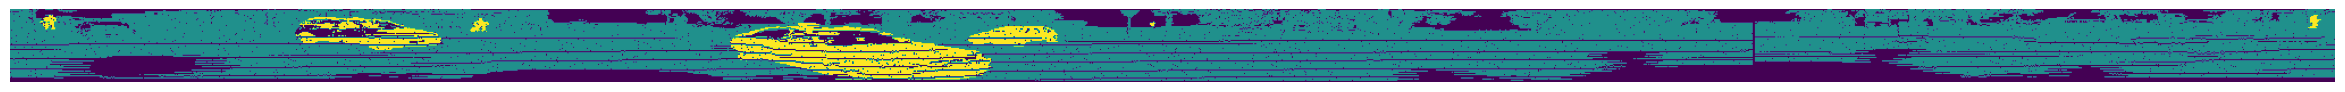

Shape of tensor: torch.Size([1, 1, 64, 2048])
Unique values in tensor: tensor([0., 1., 2.])


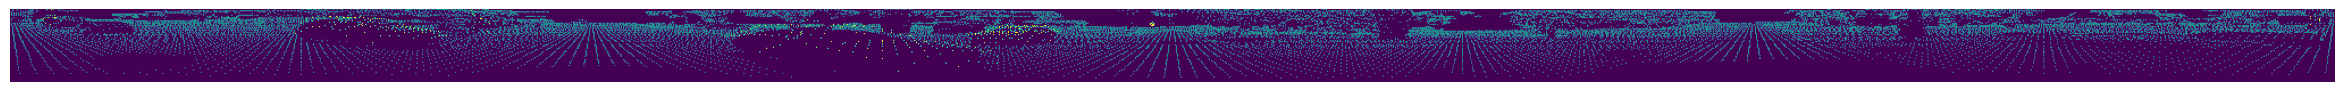

Shape of tensor: torch.Size([1, 1, 512, 512])
Unique values in tensor: tensor([0., 1., 2.])


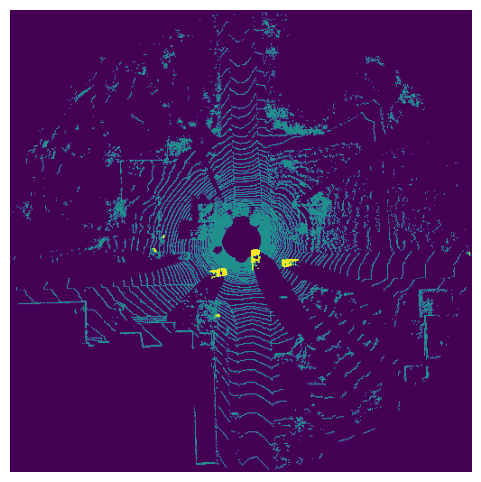

Shape of tensor: torch.Size([1, 1, 512, 512])
Unique values in tensor: tensor([0., 1., 2.])


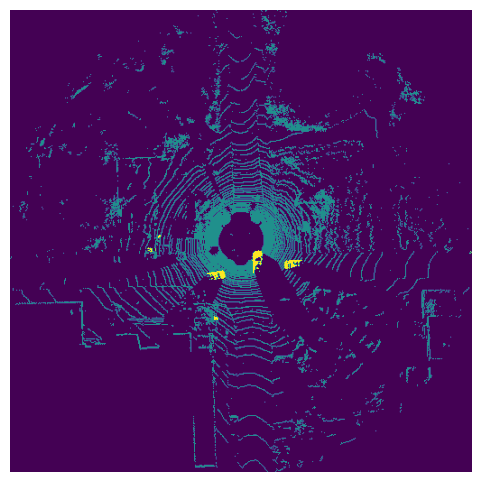

-------------------------------------------------------------------------------------------------------
Shape of tensor: torch.Size([1, 1, 512, 512])
Unique values in tensor: tensor([0., 1., 2.])


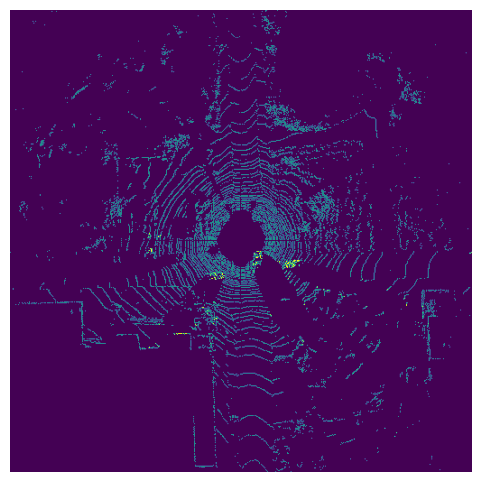

In [25]:
imsave = True

show_tensor_as_img(sphere_label, imsave, "sphere_label"), show_tensor_as_img(descartes_label_as_sphere, imsave, "descartes_label_as_sphere")
show_tensor_as_img(descartes_label, imsave, "descartes_label"), show_tensor_as_img(sphere_label_as_descartes, imsave, "sphere_label_as_descartes")

print("-------------------------------------------------------------------------------------------------------")
show_tensor_as_img(descartes_label_as_sphere_as_descartes, imsave, "descartes_label_as_sphere_as_descartes")